## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  1-2. (*)  Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews .Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    
    
</ol>



## Набор данных для последнего ДЗ

- COVID 19 диагностика https://www.kaggle.com/andrewmvd/covid19-ct-scans

- Распознавание изображений цифр в представлении языка жестов https://www.kaggle.com/ardamavi/sign-language-digits-dataset

In [1]:
import tensorflow as tf
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.8.0
TensorFlow 2.0 Hello World


In [2]:
from keras.models import Sequential
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
boston_dataset = load_boston()
X = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
y = boston_dataset.target
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
X.shape

(506, 13)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

GRID SEARCH

In [7]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from hyperopt.base import Trials
from functools import partial

In [8]:
from keras.metrics import MAE
def build_model(n_neurons, n_layers, optimizer, activation, loss_func):
  losses = {
      'MSE': tf.keras.losses.MeanSquaredError(),
      'MAE': tf.keras.losses.MeanAbsoluteError()
  }
  model = Sequential()
  model.add(Flatten(input_shape=(13,)))
  for layer in range(n_layers):
    model.add(Dense(n_neurons, activation=activation))
  model.add(Dense(1, activation='relu'))
  model.compile(optimizer=optimizer,
              loss=losses[loss_func],
              metrics=['mean_squared_error', 'mean_absolute_error'])
  return model

def objective(params, X_train, y_train, X_test, y_test):
  model = build_model(**params)
  history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2, verbose=0)
  loss, mse, mae = model.evaluate(X_test, y_test, verbose = 0)
  results={
      'loss': mse,
      'mae': mae,
      'test_loss': loss,
      'history': history,
      'status': STATUS_OK
      }
  results.update(params)
  return results

In [10]:
trials_list = []
for loss_func in ['MSE', 'MAE']:
  space = {
      'optimizer' : hp.choice('optimizer', options=['SGD','RMSProp','adam','NAdam']),
      'activation' : hp.choice('activation', options=['linear','tanh','relu']),
      'n_neurons' : hp.choice('n_neurons', np.arange(64, 320, dtype=int)),
      'n_layers' : hp.choice('n_layers', np.arange(2, 8, dtype=int)),
      'loss_func': loss_func
  }
  trials = Trials()
  best = fmin( 
              fn=partial(objective, X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test),
              space=space, 
              algo=tpe.suggest, 
              max_evals=40,
              trials=trials,)
  trials_list.append(trials)

100%|██████████| 40/40 [06:05<00:00,  9.14s/it, best loss: 12.399484634399414]


### Лучшие метрики MSE

In [12]:
pd.DataFrame(trials_list[0].results).sort_values(by=['loss']).head(8)

,loss,mae,test_loss,history,status,activation,loss_func,n_layers,n_neurons,optimizer
10,11.369458,2.189978,11.369458,<keras.callbacks.History object at 0x7f8302559...,ok,relu,MSE,5,159,adam
32,12.086656,2.252966,12.086656,<keras.callbacks.History object at 0x7f82ec648...,ok,relu,MSE,5,144,NAdam
19,12.490386,2.192690,12.490386,<keras.callbacks.History object at 0x7f8307a9d...,ok,relu,MSE,6,176,NAdam
39,12.597548,2.225987,12.597548,<keras.callbacks.History object at 0x7f82deb27...,ok,relu,MSE,3,145,adam
30,12.720878,2.274876,12.720878,<keras.callbacks.History object at 0x7f82f415c...,ok,relu,MSE,5,176,NAdam
20,12.911719,2.488693,12.911719,<keras.callbacks.History object at 0x7f82fbd60...,ok,relu,MSE,6,111,adam
26,13.339272,2.185384,13.339272,<keras.callbacks.History object at 0x7f82f8af4...,ok,relu,MSE,6,159,adam
1,13.416160,2.504509,13.416160,<keras.callbacks.History object at 0x7f8318070...,ok,relu,MSE,5,272,NAdam


In [14]:
pd.DataFrame(trials_list[1].results).sort_values(by=['loss']).head(8)

,loss,mae,test_loss,history,status,activation,loss_func,n_layers,n_neurons,optimizer
31,12.399485,2.333739,2.333739,<keras.callbacks.History object at 0x7f82bfdc5...,ok,relu,MAE,6,308,adam
21,12.428164,2.249601,2.249601,<keras.callbacks.History object at 0x7f82c766f...,ok,relu,MAE,5,205,adam
32,12.609233,2.247039,2.247039,<keras.callbacks.History object at 0x7f82bfc9d...,ok,relu,MAE,6,121,adam
5,12.772013,2.185530,2.185530,<keras.callbacks.History object at 0x7f82e394a...,ok,relu,MAE,5,205,adam
26,13.532938,2.294227,2.294227,<keras.callbacks.History object at 0x7f82cccae...,ok,relu,MAE,5,149,adam
34,14.375031,2.313162,2.313162,<keras.callbacks.History object at 0x7f82bf8dc...,ok,relu,MAE,6,205,NAdam
19,14.577812,2.304766,2.304766,<keras.callbacks.History object at 0x7f82c766f...,ok,relu,MAE,5,304,adam
36,15.171181,2.480007,2.480007,<keras.callbacks.History object at 0x7f82be29c...,ok,relu,MAE,7,77,adam


### Лучшие метрики MAE

In [24]:
pd.DataFrame(trials_list[0].results).sort_values(by=['mae']).head(4)

,loss,mae,test_loss,history,status,activation,loss_func,n_layers,n_neurons,optimizer
26,13.339272,2.185384,13.339272,<keras.callbacks.History object at 0x7f82f8af4...,ok,relu,MSE,6,159,adam
10,11.369458,2.189978,11.369458,<keras.callbacks.History object at 0x7f8302559...,ok,relu,MSE,5,159,adam
19,12.490386,2.192690,12.490386,<keras.callbacks.History object at 0x7f8307a9d...,ok,relu,MSE,6,176,NAdam
39,12.597548,2.225987,12.597548,<keras.callbacks.History object at 0x7f82deb27...,ok,relu,MSE,3,145,adam


In [23]:
pd.DataFrame(trials_list[1].results).sort_values(by=['mae']).head(4)

,loss,mae,test_loss,history,status,activation,loss_func,n_layers,n_neurons,optimizer
5,12.772013,2.185530,2.185530,<keras.callbacks.History object at 0x7f82e394a...,ok,relu,MAE,5,205,adam
32,12.609233,2.247039,2.247039,<keras.callbacks.History object at 0x7f82bfc9d...,ok,relu,MAE,6,121,adam
21,12.428164,2.249601,2.249601,<keras.callbacks.History object at 0x7f82c766f...,ok,relu,MAE,5,205,adam
26,13.532938,2.294227,2.294227,<keras.callbacks.History object at 0x7f82cccae...,ok,relu,MAE,5,149,adam


Кривая обучения лучшей модели:

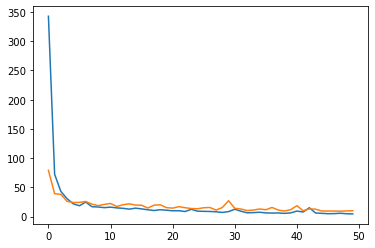

In [22]:
plt.plot(trials_list[0].results[10]['history'].history['loss'])
plt.plot(trials_list[0].results[10]['history'].history['val_loss'])
plt.show()

По результатам подбора параметров для обеих целевых метрик получены следующие результаты:
* оптимальное количество слоев для данной задачи 5-6
* оптимизаторы adam и Nadam
* функция активации слоев relu
* количество нейронов 100-200
